In [1]:
import networkx as nx
import time
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import njit

## Plots

In [2]:
def plot_singles(simmulate_noise=False):
    plt.figure(figsize=(10,5))
    for i in range(0,N):
        if i in inh:  plt.plot(X.T[i], c= 'red', lw=1) 
        if i in exc:  plt.plot(X.T[i], c='blue', lw=1, alpha=0.3 ) 

    plt.legend(['inh','exc'],labelcolor=['red','blue'], loc = 'upper left');
    #plt.xlim([0,20000])
    if Y is not None:
        plt.figure(figsize=(10,5))
        for i in range(0,N):
            if i in inh:  plt.plot(Y.T[i], c= 'red', lw=1) 
            if i in exc:  plt.plot(Y.T[i], c='blue', lw=1, alpha=0.3 ) 
        plt.title('$\gamma$={}, $\sigma$ = {}'.format(tau,sigma));
        plt.legend(['inh','exc'],labelcolor=['red','blue'], loc = 'upper left');
    return

In [3]:
def plot_activities(simmulate_noise=False):
    fig = plt.figure(figsize=(20,5))
    ax = fig.subplots(1,2, sharey=True, sharex=True)
    burnin= 0

    if simmulate_noise:
        S_inh_n=np.sum(Y[:,inh], axis=1)/len(inh)
        ax[1].plot(S_inh_n[burnin:],lw=1,color='red', label='inh');
        S_exc_n=np.sum(Y[:,exc], axis=1)/len(exc)
        ax[1].plot(S_exc_n[burnin:],lw=1,color='blue', label='exc');
        S_n=np.sum(Y, axis=1)/N
        ax[1].plot(S_n[burnin:],lw=1,color='green', label='global');
        ax[1].legend(loc='upper left')
        ax[1].set_title('Noisy simualtion with $\sigma=1/\sqrt{N}$', size=20)
        ax[1].set_xlabel('Timestep',size=15)


    S_inh=np.sum(X[:,inh], axis=1)/len(inh)
    ax[0].plot(S_inh[burnin:],lw=1,color='red', label='inh');
    S_exc=np.sum(X[:,exc], axis=1)/len(exc)
    ax[0].plot(S_exc[burnin:],lw=1,color='blue', label='exc');
    S=np.sum(X, axis=1)/N
    ax[0].plot(S[burnin:],lw=1,color='green', label='global');
    ax[0].legend(loc='upper left')
    ax[0].set_title('Noise-free simualtion with $\sigma=1/\sqrt{N}$', size=20)
    ax[0].set_xlabel('Timestep',size=15)


    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    e, v = np.linalg.eig(W)
    e_r0 = np.real(e)
    e_i0 = np.imag(e)
    biggest_norm = np.sort(list(set(np.round(np.sqrt(e_r0**2 + e_i0**2),5))))[-1] 
    biggest_real = np.sort(list(set(np.round((e_r0),5))))[-1] 

    ax[0].text((steps-burnin)*1.07, np.mean(ax[1].get_ylim()), '$| \lambda_o |=${}'.format(round(biggest_norm,2)), fontsize=15,
            verticalalignment='top', bbox=props);
    return
#ax[0].set_xlim([0000,32000])
#ax[0].set_ylim([0,.002])
#b = [gamma*np.round(x,3) for x in mean_syn(W)]
#ax[0].plot(range(0,i),np.ones(i)*b[0])

## Functions

### Generate matrix

In [158]:
def full(N, muE, muI=None, nI=None):
  '''
  Returns a fully connected matrix with a fraction
  nI of inhibitory synapses. The weights are sampled from
  Normal distributions being muE/I their means
  '''
  inh = []
  if nI is not None:
    inh = random.sample(range(N), round(nI*N))
  M = np.empty((N,N))
  for i in range(N):
    # Inhibitory
    if i in inh:  M[i,:] = np.random.normal(-muI,1/N,N) 
    #Excitatory
    else:  M[i,:] =  np.random.normal(muE,1/N,N)
  # Exclude self-interactions  
  np.fill_diagonal(M, np.zeros(N)) 
  return M, inh

def sparse2(M,p=None,k=None):
    '''K_out = p(N-1)'''
    N = len(M)
    if p is not None: k = round(p*(N-1))
    Msparse = np.zeros((N,N))   
    
    for i in range(N):
        nonzero = random.sample(range(N), k)
        Msparse[i,nonzero] = M[i,nonzero]  
    
    return Msparse

def modulate_II(M, val=0):
    for i in inh:
        for j in inh:
            M[i,j] = val
    return M

In [140]:
def plot_eigenvals(W,plot=True, onlyplot=False):
    e, v = np.linalg.eig(W)
    e_r0 = np.real(e)
    e_i0 = np.imag(e)
    
    if plot:
        circle1=plt.Circle((0, 0), 1, color='pink')
        plt.gca().add_patch(circle1)
        plt.plot(e_r0,e_i0, 'o ',lw=1,marker='o', ms=3, markeredgewidth=2,  mec='black',mfc='red', label='N=$10$')
        plt.axis('equal')
        #print('Max modulus: ',np.sort(np.sqrt(e_r0**2 + e_i0**2))[-5:])
        plt.plot(e_r0,e_i0, 'o ',lw=1,marker='o', ms=5, markeredgewidth=2,  mec='black',mfc='red', label='N=$10$');
        if onlyplot: return
    # Sort unique values in descending order
    sort_by_norm = np.sort(list(set(np.round(np.sqrt(e_r0**2 + e_i0**2),5))))[::-1] 
    sort_by_real = np.sort(list(set(np.round((e_r0),5))))[::-1] 
    return sort_by_norm, sort_by_real

def mean_syn(W):
    '''Obtain mean synaptic weights'''
    return [np.mean([np.mean(W[:,j][W[:,j]!=0]) for j in set(range(0,N)) - set(inh)]),
           np.mean([np.mean(W[:,j][W[:,j]!=0]) for j in set(inh)]),
            np.mean([np.mean(W[:,j][W[:,j]!=0]) for j in set(range(0,N))])]


## Simulation

In [141]:
def set_params(**kwargs):
    pars = {}
  
    # Network parameters 
    pars['N'] = 100 # Network size
    pars['muE'] = 1.  # Average Excitatory strength
    pars['muI'] = 4*pars['muE']  # Average Inhibitory strength
    pars['sparsity'] = 0.2
    
    # Saturating function parameters
    pars['b'] = 1.2      # Gain of the E population ()
    pars['theta'] = 2.8  # Threshold of the E population

    # Model parameters
    pars['tau'] = 1.     # Timescale of the population [ms]
    pars['I_ext'] = 0.   # External input
    pars['sigma'] = 1/np.sqrt(N) 

    # simulation parameters
    pars['steps'] = int(10*1e4) # Simulation steps
    pars['dt'] = .001       # Simulation time step [ms]
    # Total duration of simulation = steps*dt [ms]

    # External parameters if any
    pars.update(kwargs)

    return pars

In [142]:
'''Create original state'''
def initial_state(N, mode = 'Random'):
    if mode=='Random':
        # Random
        x_t = np.random.uniform(0,1,N)
    if mode=='Gaussian':
        # Gaussian
        x_t = np.random.normal(.5,1/N,N)
    if mode=='Uniform':
        # Uniform
        x_t = np.ones(N)*.5
    if mode=='Half':
        # Half of the neurons are active
        x_t = np.zeros(N)
        active = np.random.choice(N,round(N/2))
        x_t[active]=1
    if mode=='Single':
        # one active excitatory neuron
        x_t = np.zeros(N)
        active = random.choice(exc)
        initial_active=.5
        x_t[active]=initial_active
        
    return x_t


In [186]:

theta, b = 2.8, 1.2

@njit(nopython=True)
def F(z): 
    #F(z) = max(0,tanh(z))  
    f = np.array([np.max(np.array([0, np.tanh(x)])) for x in z])
    return f

'''
@njit(nopython=True)
def F(z):
    #F(z) = Cool differentiable sigmoid function 
    f = 1/(1+np.exp(-b*(z-theta)))-1/(1+np.exp(b*theta))      
    return f                                  
'''
@njit(nopython=True)
def drive(W,x_t): 
    # W = synaptic weight matrix
    # z(t) = Σ w_{ij} * x_j(t) 
    return  np.array([np.sum(np.multiply(W[:,j], x_t)) for j in range(0,N)]) 


@njit(nopython=True)
def noise(dt,N):
    return np.sqrt(dt)*np.random.normal(loc=0.0, scale=np.sqrt(1/N),size=N)

@njit(nopython=True)
def Euler2(x_t,W,I_ext):
    xdot = -x_t + F(drive(W,x_t)+I_ext)
    # Integrate with Euler-Maruyama
    x_t = x_t + dt*(xdot)/tau
    #x_t = np.array([np.max(np.array([0, x])) for x in x_t]) # Non-negative rate
    return x_t

def OU_process(pars, tau_ou = None, seed=False):
    # Params
    N, steps, dt, sigma =  pars['N'], pars['steps'], pars['dt'], pars['sigma']
    
    if tau_ou == None: tau_ou = dt

    # set random seed
    if seed:
        np.random.seed(seed=seed)
    else:
        np.random.seed()

    # Initialize
    I_ou = np.zeros((steps,N))
    I_ou[0] = np.random.randn(N) * sigma

    # generate OU
    for i in range(steps - 1):
        I_ou[i+1,:] = (I_ou[i,:]
                     + dt / tau_ou * (0. - I_ou[i,:])
                     + np.sqrt(2 * dt / tau_ou) * sigma * np.random.randn(N))

    return I_ou



def simulate(W,x_t, pars, simmulate_noise=False):
    '''Simulation parameters'''
    global tau 
    global b 
    global theta 
    global I_ext 
    global sigma 
    global dt 
    global steps 
    # Set parameters
    tau, b, theta = pars['tau'], pars['b'], pars['theta']
    I_ext, sigma = pars['I_ext'], pars['sigma']
    dt, steps = pars['dt'], pars['steps']
    
    
    X = np.zeros((steps+1,N))
    X[0] = x_t
    Y = None
    
    if simmulate_noise:
        # Generate noise beforehand as OU process
        I_OU = OU_process(pars, tau_ou = .1, seed=False) # Simulate noise
        # Define and fill vars
        y_t = x_t.copy()
        Y = np.zeros((steps+1,N))
        Y[0] = y_t


    '''Main loop'''
    #for i in tqdm(range(steps)):
    for i in range(steps):
        x_t = Euler2(x_t,W,I_ext)
        X[i+1,:] = x_t 
        if simmulate_noise:
            y_t = Euler2(y_t,W,I_ext=I_ext+I_OU[i,:])
            Y[i+1,:] = y_t 
    
    return X, Y
 

C:\Users\Usuario\anaconda3\lib\site-packages\numba\core\decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [187]:
W_o = W.copy()/3

6 active modes
Wall time: 651 ms


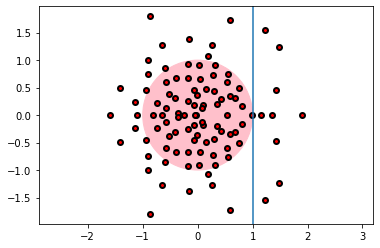

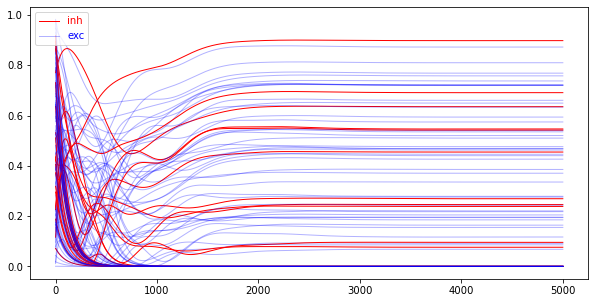

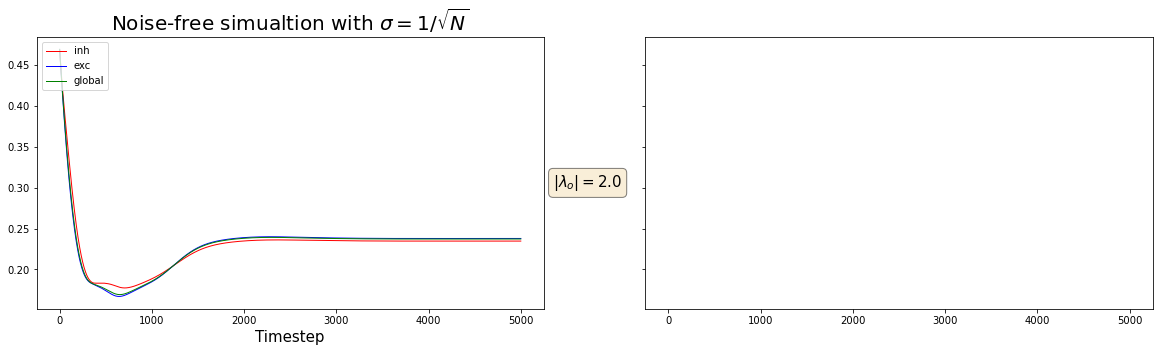

In [210]:
%%time

N, muE,nI = 100, 1, 0.2
W, inh = full(N, muE= muE, muI=4*muE, nI=nI) # Fully connected
exc=list(set(range(N))-set(inh))
W = sparse2(W,p=0.2) # Add sparsity
a,b = plot_eigenvals(W,False)
W = W/a[0]

W = W*2

e, v = np.linalg.eig(W)
plot_eigenvals(W,True);
plt.axvline(x=1)
print('%d active modes' %sum(np.array(list(set(np.round(np.real(e),5))))>=1))
#mean_syn(W)

pars = set_params(steps=int(5000),I_ext=0.,tau=.5, dt= 0.01)
x_t = initial_state(N, 'Random')
simmulate_noise = False
X,Y= simulate(W,x_t, pars, simmulate_noise=simmulate_noise)  
plot_singles(simmulate_noise)
plot_activities(simmulate_noise)

In [ ]:
%%time

Is = np.linspace(-0.5,0.5,50)
Ms = np.linspace(1,10,50) # Moduli
XX, YY = np.meshgrid(Is, Ms, indexing='xy')
positions = np.vstack([XX.ravel(), YY.ravel()])

N, muE,nI = 100, 1, 0.2

# Create and resize matrix
def generate_W(M):
    W, inh = full(N, muE= muE, muI=4*muE, nI=nI) # Fully connected
    W = sparse2(W,p=0.2) # Add sparsity
    a,b = plot_eigenvals(W,False)
    W = W/a[0]
    W = W*M
    return W


pars = set_params(steps=int(5*1e4),I_ext=.5 ,tau=0.5, dt= 0.001)
simmulate_noise = False

dic = {}
for j in range(0,1):
    for i in tqdm(range(0,positions.shape[1])):
        I = positions[0][i]
        M = positions[1][i]


        W = generate_W(M)
        x_t = initial_state(N, 'Random')

        pars['I_ext'] = I 
        X,Y= simulate(W,x_t, pars, simmulate_noise=simmulate_noise)  
        S = np.mean(X[20000:],axis=0)
        a= np.mean(S)
        b = np.var(S)
        dic[I,M] = [a,b]


 52%|██████████████████████████████████████████                                       | 52/100 [02:32<02:28,  3.10s/it]

In [ ]:
%%time

muEs = np.linspace(-0.01,0.1,100)
g = np.linspace(0,5,100) # Moduli
XX, YY = np.meshgrid(Is, Ms, indexing='xy')
positions = np.vstack([XX.ravel(), YY.ravel()])

N, muE,nI = 100, 1, 0.2

# Create and resize matrix
def generate_W(muE, g):
    W, inh = full(N, muE= muE, muI=g*muE, nI=.2) # Fully connected
    W = sparse2(W,p=0.2) # Add sparsity
    a,b = plot_eigenvals(W,False)
    W = W/a[0]
    W = W*M
    return W


pars = set_params(steps=int(5000),I_ext=0.,tau=.5, dt= 0.01)
simmulate_noise = False

dic = {}
for j in range(0,50):
    for i in tqdm(range(0,positions.shape[1])):
        g = positions[0][i]
        muE = positions[1][i]


        W = generate_W(muE,g)
        x_t = initial_state(N, 'Random')

        pars['I_ext'] = I 
        X,Y= simulate(W,x_t, pars, simmulate_noise=simmulate_noise)  
        S = np.mean(X[2000:],axis=0)
        a= np.mean(S)
        b = np.var(S)
        dic[j,I,M] = [a,b]


In [ ]:
dic2 = {}
 
for key in dic.keys():
    S = np.mean(X[20000:],axis=0)
    a= np.mean(S)
    b = np.var(dic[key][20000:],axis=1)/N
    dic2[key] = [a,b]
plt.plot(b)

In [65]:
vals_i = np.zeros((2500, 2))
for i in range(10):
    keys_i = [x for x in list(dic.keys()) if x[0]==i]
    vals_i += np.array([np.array(dic[j]) for j in keys_i])

In [68]:
np.array([x[0] for x in vals_i]).reshape(50,50)

array([[4.29720672, 4.21538592, 4.24488563, ..., 3.9800203 , 4.00832539,
        4.4184591 ],
       [4.29821345, 4.28312338, 3.65035772, ..., 3.90827853, 4.38590149,
        3.88227474],
       [4.31065838, 3.85280845, 4.57709894, ..., 3.98620085, 4.04738201,
        4.1637361 ],
       ...,
       [3.97761345, 5.06509875, 5.06157741, ..., 4.87237767, 4.91758253,
        4.75758246],
       [4.47729089, 4.82119283, 4.9442154 , ..., 4.7820372 , 5.38559903,
        5.04461651],
       [4.49166945, 5.38809723, 4.55689093, ..., 4.50692298, 4.48830579,
        4.46633324]])

In [ ]:
X = dic[(-0.3979591836734694, 0.0)]
plt.plot(np.mean(X[2000:],axis=0),'r');

<ipython-input-137-4cc10728e231>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(X,Y,Z);


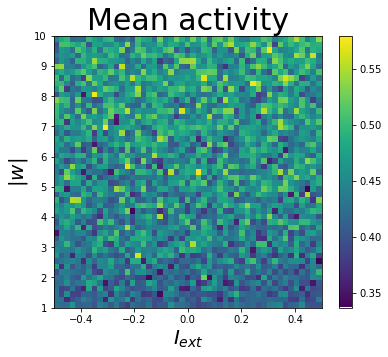

In [137]:
X, Y = np.meshgrid(Is, Ms, indexing='xy')
#Z=np.array([x[0] for x in list(dic.values())]).reshape(len(Ms),len(Is))
Z = np.array([x[0] for x in vals_i]).reshape(50,50)/10

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,figsize=(6,5))
im = plt.pcolormesh(X,Y,Z);
axs.set_title('Mean activity', fontsize=30)

axs.set_xlabel(r'$I_{ext}$',fontsize=20)
axs.set_ylabel('$|w|$',fontsize=20)
fig.colorbar(im)

In [ ]:
X, Y = np.meshgrid(Is, Ms, indexing='xy')
#X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

positions.shape[1]

In [ ]:
a,b = plot_eigenvals(W,False)
W = W/a[0]
W = W*5
e, v = np.linalg.eig(W)
plot_eigenvals(W,True);
plt.axvline(x=1)
print('%d active modes' %sum(np.array(list(set(np.round(np.real(e),5))))>=1))
#mean_syn(W)
